## SIT796 Reinforcement Learning

Pass Task 4.2 - Monte Carlo Methods Implementation  
**Angus Maiden** | ID 220595465

This task implements and compares the off-policy and on-policy Monte Carlo control methods for finding an optimal policy in playing Blackjack.

In [1]:
# Import the necessary libraries.
import sys
import gym
import random
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

# Invoke the Blackjack environment.
env = gym.make('Blackjack-v0')

### On-policy Monte Carlo Control

In [2]:
# Initialise lists to hold total episode rewards.
total_episode_rewards = []
episode_wins = []

def get_probs(Q_s, epsilon, nA): #nA is no. of actions in the action space
    # Obtains the action probabilities corresponding to epsilon-greedy policy.
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s
  
def generate_episode_from_Q(env, Q, epsilon, nA):
    # Generates an episode from following the epsilon-greedy policy.
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        
        if done:
            if reward > 0:
                win = 1
            else:
                win = 0
            break
    return episode, win

def update_Q(env, episode, win, Q, alpha, gamma):
    
    # Updates the action-value function estimate using the most recent episode.
    states, actions, rewards = zip(*episode)
                
    # Track total rewards and wins per episode.
    total_episode_rewards.append(sum(rewards))
    episode_wins.append(win)
    
    # Prepare for discounting.
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [3]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    
    # Initialize empty dictionary of arrays.
    Q = defaultdict(lambda: np.zeros(nA))
    
    # Initialise epsilon.
    epsilon = eps_start
    
    # Loop over episodes.
    for i_episode in range(1, num_episodes+1):
        
        # Monitor progress.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # Update the value of epsilon.
        epsilon = max(epsilon*eps_decay, eps_min)
        
        # Generate an episode by following epsilon-greedy policy.
        episode, win = generate_episode_from_Q(env, Q, epsilon, nA)
        
        # Update the action-value function estimate using the episode.
        Q = update_Q(env, episode, win, Q, alpha, gamma)
    
    # Determine the policy corresponding to the final action-value function estimate.
    P = dict((k,np.argmax(v)) for k, v in Q.items())
    return P, Q

In [4]:
# Obtain the estimated optimal policy and action-value function.
P, Q = mc_control(env, 500000, 0.015)

# Obtain the corresponding state-value function.
V = dict((k,np.max(v)) for k, v in Q.items())

Episode 500000/500000.

<function matplotlib.pyplot.show(close=None, block=None)>

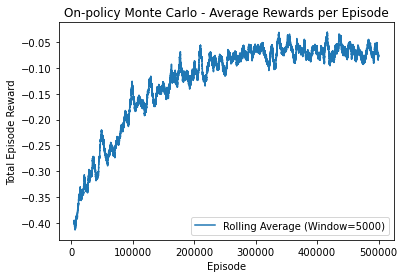

In [39]:
# Plot the rewards as a moving average (to see trends).
rolling_episode_rewards = pd.DataFrame(total_episode_rewards).rolling(5000).mean()
plt.plot(rolling_episode_rewards)
plt.title('On-policy Monte Carlo - Average Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Episode Reward')
plt.legend(['Rolling Average (Window=5000)'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

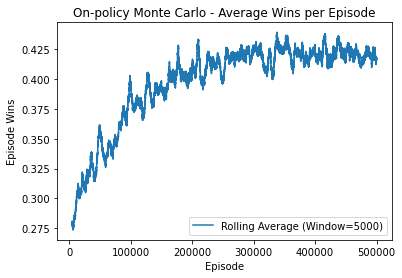

In [40]:
# Plot the wins as a moving average (to see trends).
rolling_episode_wins = pd.DataFrame(episode_wins).rolling(5000).mean()
plt.plot(rolling_episode_wins)
plt.title('On-policy Monte Carlo - Average Wins per Episode')
plt.xlabel('Episode')
plt.ylabel('Episode Wins')
plt.legend(['Rolling Average (Window=5000)'])
plt.show

### Off-policy Monte Carlo Control

In [18]:
# Initialise lists to hold total episode rewards.
offpolicy_total_episode_rewards = []
offpolicy_episode_wins = []

def offpolicy_mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    
    # Initialize empty dictionary of arrays.
    Q = defaultdict(lambda: np.zeros(nA))
    C = defaultdict(lambda: np.zeros(nA))
    P = defaultdict(lambda: np.random.choice(np.arange(nA)))
    B = defaultdict(lambda: np.random.choice(np.arange(nA)))
    
    # Initialise epsilon.
    epsilon = eps_start
    
    # loop over episodes.
    for i_episode in range(1, num_episodes+1):
        
        # Monitor progress.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # Update epsilon.
        epsilon = max(epsilon*eps_decay, eps_min)
        
        # Generate an episode by following epsilon-greedy policy.
        episode, win = generate_episode_from_Q(env, Q, epsilon, nA)
        
        # Updates the action-value function estimate using the most recent episode .
        states, actions, rewards = zip(*episode)

        # Track total rewards and wins per episode.
        offpolicy_total_episode_rewards.append(sum(rewards))
        offpolicy_episode_wins.append(win)       
            
        # Define B policy (a dictionary holding an arrays of the probabilities
        # of taking each action in each state).
        for i, state in enumerate(states):
            B[state] = get_probs(Q[state], epsilon, nA)
        
        # Initialise G and W.
        G = 0
        W = 1 
        
        # Loop for each step of the episode, t = T-1, T-2, ... 0.
        for i, state in reversed(list(enumerate(states))):
            
            # Update returns.
            G = gamma*G + rewards[i]
            
            # Update C.
            C[state][actions[i]] += W
            
            # Update state-action value.
            Q[state][actions[i]] += (W/C[state][actions[i]])*(G - Q[state][actions[i]])
            
            # Update state policy to be argmax(Q), breaking ties randomly.
            P[state] = int(np.random.choice(np.flatnonzero(Q[state] == Q[state].max())))
            
            # If the episode action at time time is not equal to the new policy,
            # break the loop (which proceeds to the next episode).
            if actions[i] != P[state]:
                break
            
            # Update W.
            W = W/B[state][actions[i]]
    
    # Determine the policy corresponding to the final action-value function estimate.
    return P, Q

In [19]:
# Obtain the estimated optimal policy and action-value function.
offpolicy_P, offpolicy_Q = offpolicy_mc_control(env, 500000, 0.015)

# Obtain the corresponding state-value function.
offpolicy_V = dict((k,np.max(v)) for k, v in offpolicy_Q.items())

Episode 500000/500000.

<function matplotlib.pyplot.show(close=None, block=None)>

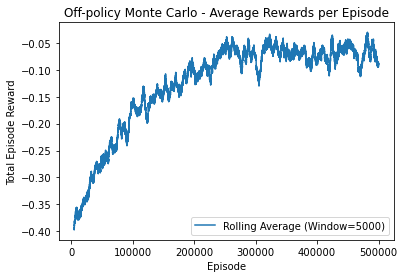

In [41]:
# Plot the rewards as a moving average (to see trends).
offpolicy_rolling_episode_rewards = pd.DataFrame(offpolicy_total_episode_rewards).rolling(5000).mean()
plt.plot(offpolicy_rolling_episode_rewards)
plt.title('Off-policy Monte Carlo - Average Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Episode Reward')
plt.legend(['Rolling Average (Window=5000)'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

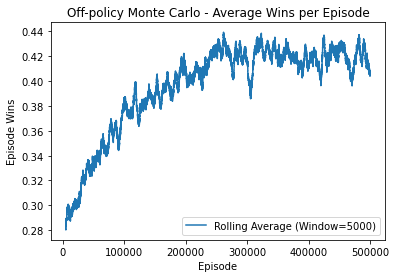

In [42]:
# Plot the wins as a moving average (to see trends).
offpolicy_rolling_episode_wins = pd.DataFrame(offpolicy_episode_wins).rolling(5000).mean()
plt.plot(offpolicy_rolling_episode_wins)
plt.title('Off-policy Monte Carlo - Average Wins per Episode')
plt.xlabel('Episode')
plt.ylabel('Episode Wins')
plt.legend(['Rolling Average (Window=5000)'])
plt.show